## Required PIP Installations in Terminal Before Running Code

In [51]:
# git clone https://github.com/facebookresearch/Pearl.git
# cd Pearl
# git install -e .
# cd ..
#
# pip install gym-trading-env  



In [1]:
import gym_trading_env
from gym_trading_env.downloader import download, EXCHANGE_LIMIT_RATES
from gym_trading_env.renderer import Renderer
import gymnasium as gym
import datetime
import pandas as pd
import numpy as np
import os # used to get current directory
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from hyperopt import hp,tpe,fmin, STATUS_OK, Trials # for hyperparameterization
from hyperopt.pyll.stochastic import sample

# Import all the Pearl related methods
from pearl.pearl_agent import PearlAgent
from pearl.action_representation_modules.one_hot_action_representation_module import (
    OneHotActionTensorRepresentationModule,
)
from pearl.policy_learners.sequential_decision_making.deep_q_learning import (
    DeepQLearning,
)
from pearl.replay_buffers.sequential_decision_making.fifo_off_policy_replay_buffer import (
    FIFOOffPolicyReplayBuffer,
)
from pearl.utils.instantiations.environments.gym_environment import GymEnvironment
from pearl.policy_learners.sequential_decision_making.implicit_q_learning import ImplicitQLearning
from pearl.utils.functional_utils.train_and_eval.offline_learning_and_evaluation import (
    get_offline_data_in_buffer,
    offline_evaluation,
    offline_learning,
)
from pearl.neural_networks.sequential_decision_making.actor_networks import VanillaContinuousActorNetwork
from pearl.pearl_agent import PearlAgent
from pearl.action_representation_modules.one_hot_action_representation_module import (
    OneHotActionTensorRepresentationModule,
)
from pearl.policy_learners.sequential_decision_making.deep_q_learning import (
    DeepQLearning,
)
from pearl.replay_buffers.sequential_decision_making.fifo_off_policy_replay_buffer import (
    FIFOOffPolicyReplayBuffer,
)
from pearl.utils.instantiations.environments.gym_environment import GymEnvironment
import torch # used for calculating the mean when evaluating Pearl training performance

##FOR USE WITH VANILLAQVALUENETWORK
#from pearl.neural_networks.sequential_decision_making.q_value_networks import VanillaQValueNetwork

experiment_seed = 42

c:\Users\548253\AppData\Local\anaconda3\envs\gym-trader5\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
# run this twice
import warnings
warnings.simplefilter('ignore')

In [73]:
# Download data from site
EXCHANGE_LIMIT_RATES["binanceus"] = {
    "limit" : 200, # One request will query 200 data points (aka candlesticks).
    "pause_every" : 120, # it will pause every 120 requests.
    "pause" : 2, # the pause will last 2 seconds.
}
download(
    exchange_names = ["binanceus"],
    symbols= ["ICP/USDT"],
    timeframe= "1h",
    dir = "data",
    since= datetime.datetime(year= 2024, month= 9, day=1),
)

ICP/USDT downloaded from binanceus and stored at data/binanceus-ICPUSDT-1h.pkl


In [74]:
def get_data(filename: str):
    if filename[:6] != "./data/":
        filename = "./data/" + filename

    # df is a DataFrame with original columns : "open", "high", "low", "close", "Volume USD"
    df = pd.read_pickle(filename)

    #df.sort_index(inplace= True)

    # Create the feature : ( close[t] - close[t-1] )/ close[t-1]
    df["feature_close"] = df["close"].pct_change()

    # Create the feature : open[t] / close[t]
    df["feature_open"] = df["open"]/df["close"]

    # Create the feature : high[t] / close[t]
    df["feature_high"] = df["high"]/df["close"]

    # Create the feature : low[t] / close[t]
    df["feature_low"] = df["low"]/df["close"]

    # Create the feature : volume[t] / max(*volume[t-7*24:t+1])
    # Create the feature : volume[t] / max(*volume[2])
    df["feature_volume"] = df["volume"] / df["volume"].rolling(2).max()

    # Simple moving averages of 10 and 5 units of time
    df["feature_sma10"] = df["close"].rolling(10).mean()
    df["feature_sma5"] = df["close"].rolling(5).mean()

    df.dropna(inplace= True) # Clean again !
    # Each step, the environment will return 5 inputs  : "feature_close", "feature_open", "feature_high", "feature_low", "feature_volume"

    return df 



In [75]:
df = get_data("binanceus-ICPUSDT-1h.pkl")
df

,open,high,low,close,volume,date_close,feature_close,feature_open,feature_high,feature_low,feature_volume,feature_sma10,feature_sma5
date_open,,,,,,,,,,,,,
2024-09-01 01:00:00,7.526,7.526,7.484,7.484,1.74,2024-09-01 02:00:00,-0.008610,1.005612,1.005612,1.000000,1.000000,7.5221,7.5436
2024-09-01 02:00:00,7.436,7.436,7.436,7.436,27.14,2024-09-01 03:00:00,-0.006414,1.000000,1.000000,1.000000,1.000000,7.5173,7.5172
2024-09-01 03:00:00,7.436,7.436,7.436,7.436,0.00,2024-09-01 04:00:00,0.000000,1.000000,1.000000,1.000000,0.000000,7.5124,7.4908
2024-09-01 05:00:00,7.375,7.375,7.360,7.360,16.01,2024-09-01 06:00:00,-0.010221,1.002038,1.002038,1.000000,1.000000,7.4890,7.4304
2024-09-01 06:00:00,7.360,7.360,7.360,7.360,0.00,2024-09-01 07:00:00,0.000000,1.000000,1.000000,1.000000,0.000000,7.4746,7.4056
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-01 02:00:00,9.046,9.097,9.046,9.097,1.44,2024-10-01 03:00:00,-0.002741,0.994394,1.000000,0.994394,0.200837,9.0989,9.0630
2024-10-01 03:00:00,9.148,9.245,9.148,9.245,21.90,2024-10-01 04:00:00,0.016269,0.989508,1.000000,0.989508,1.000000,9.1086,9.1018
2024-10-01 04:00:00,9.250,9.286,9.227,9.286,40.04,2024-10-01 05:00:00,0.004435,0.996123,1.000000,0.993646,1.000000,9.1275,9.1598


## Split the data into train and test data; need consecutive dates in each

In [76]:
split_date=pd.to_datetime('09/25/2024')
train_df=df[:split_date];
test_df=df[split_date:];


## Define Reward Functions

In [77]:
# function is a logarithm of the quotient of the last last 2 timesteps (one hour apart)
def log_reward_function(history):
        return np.log(history["portfolio_valuation", -1] / history["portfolio_valuation", -2])

# function is the difference between the last 2 time steps
def diff_reward_function(history):
        return history["portfolio_valuation", -1] - history["portfolio_valuation", -2]

# An total growth of the portfolio since first timestep
def cumulative_reward_function(history):
        return np.diff(history["portfolio_valuation", -1] , history["portfolio_valuation", 0])/len(history["portfolio_valuation"])

# Shape Ratio reward function
def shape_reward_function(history):
        return history["portfolio_valuation", -1] /np.std(history["portfolio_valuation"])

# Final evaluation (total portfolio increase/decrease)
def final_evalulation(history):
        return (history["portfolio_valuation", -1] / history["portfolio_valuation", 0]) - 1

def n_trades(history):
        return sum(np.abs(np.diff(history['position'])))

In [78]:
def make_env(env_name, df, positions, reward_function, trading_fees, daily_borrow_interest=0.000072):
# Trading Fees and Daily Borrow Interest are ratios (so percent / 100)
#
# Positions are the actions the agent can take (buy/sell/short/nothing) as ranges -inf to inf including decimal values.
# These are the possible actions our agent will take. Sample values:
#      1 = Long entire portfolio value = spend entire portfolio value on buying X, betting the price of X will rise and can sell for a profit
#     -1 = Short entire portfolio value = Borrow & immediately sell X worth the entire portfolio value, betting the price of X will drop and can buy back
#     0.5= Long half portfolio value
#      2 = Long double portfolio value = Borrow $ equal to your portfolio then spend that + original portfolio value buying X, betting X will rise and can sell for a profit
#     -2 = Short double portfolio value
#      0 = Do nothing at this time

    # Calculate the interest rate based off the amount of time between timesteps compared
    # to the daily interest rate (daily_borrow_interest)
    timestep_size = df.index[1]-df.index[0]
    borrow_interest_per_timestep = daily_borrow_interest * timestep_size / pd.Timedelta("1 day")
    
    env = gym.make("TradingEnv",
             name = env_name,
             df = df,
             positions = positions,
             reward_function = reward_function,
             trading_fees = trading_fees / 100,
             borrow_interest_rate = borrow_interest_per_timestep,
        )
    
    env.add_metric(name="position_change", function=n_trades)

    return env



In [79]:

# reward_function = log_reward_function
# train_env = gym.make("TradingEnv",
#         name= "ICPUSD",
#         df = train_df,
#         positions = [ -1, 0, 1], # -1 (=SHORT), 0(=OUT), +1 (=LONG)
#         reward_function = reward_function,
#         trading_fees = 0.01/100, # 0.01% per stock buy / sell (Binance fees)
#         borrow_interest_rate= 0.0003/100, # 0.0003% per timestep (one timestep = 1h here)
#     )


In [80]:
train_env_name = "ICP 1-Hour Train"
test_env_name = "ICP 1-Hour Test"
reward_function = log_reward_function
positions = [ -1, 0, 1]
trading_fees = 0.01 / 100 # 0.01% per stock buy / sell (Binance fees)
daily_rate = 0.000072 # 0.0072% daily interest

train_env = make_env(train_env_name, train_df, positions, reward_function, trading_fees, daily_rate)
test_env = make_env(test_env_name, test_df, positions, reward_function, trading_fees, daily_rate)

train_env_original = train_env
test_env_original = test_env

In [81]:
obs,info=train_env.reset()
info

{'idx': 0,
 'step': 0,
 'date': np.datetime64('2024-09-01T01:00:00.000000000'),
 'position_index': 1,
 'position': np.int64(0),
 'real_position': np.int64(0),
 'data_date_close': Timestamp('2024-09-01 02:00:00'),
 'data_volume': 1.74,
 'data_high': 7.526,
 'data_low': 7.484,
 'data_close': 7.484,
 'data_open': 7.526,
 'portfolio_valuation': 1000.0,
 'portfolio_distribution_asset': 0,
 'portfolio_distribution_fiat': np.float64(1000.0),
 'portfolio_distribution_borrowed_asset': 0,
 'portfolio_distribution_borrowed_fiat': 0,
 'portfolio_distribution_interest_asset': 0,
 'portfolio_distribution_interest_fiat': 0,
 'reward': 0}

## Make Wrapper Environment for Pearl

In [106]:
def train_model(
        train_env, 
        epochs=5, 
        hidden_dims=[64, 64], 
        training_rounds=20,
        learning_rate = 0.001,
        discount_factor = 0.99,
        batch_size = 128,
        target_update_freq = 10,
        soft_update_tau = 0.75,  # a value of 1 indicates no soft updates
        is_conservative = False,
        conservative_alpha = False,
        **kwargs):
    
    # Apply Pearl Wrapper to the training environment; makes it easier for Pearl to interact with
    train_env = GymEnvironment(train_env)
    
    num_actions = train_env.action_space.n
    agent = PearlAgent(
        policy_learner=DeepQLearning(
        state_dim=train_env.observation_space.shape[0],
        action_space=train_env.action_space, 
        hidden_dims=list(hidden_dims),
        training_rounds=training_rounds,
        learning_rate = learning_rate,
        discount_factor = discount_factor,
        batch_size = batch_size,
        target_update_freq = target_update_freq,
        soft_update_tau = soft_update_tau,  # a value of 1 indicates no soft updates
        is_conservative = is_conservative,
        conservative_alpha = conservative_alpha,
        action_representation_module=OneHotActionTensorRepresentationModule(
            max_number_actions=num_actions
        ),
    ),
    replay_buffer=FIFOOffPolicyReplayBuffer(10_000),
    )

    losses=[]
    
    n_epochs=epochs
    for i in tqdm(range(n_epochs)):
        observation, action_space = train_env.reset()
        agent.reset(observation, action_space)
        done = False
        while not done:
            action = agent.act(exploit=False)
            action_result = train_env.step(action)
            
            agent.observe(action_result)
            loss=agent.learn()
            [losses.append(l) for l in loss['loss']]
            done = action_result.done

    # For plotting purposes, limit all loss values to 1 so the scale of huge
    # losses do not make all other lososes look like 0
    # Ex: first loss 6,000 whereas other losses are 0.07
    losses = [min(loss, 1) for loss in losses]

    plt.plot(losses[:1000])

    # Unwrap the Pearl-wrapped environment
    train_env=train_env.env.unwrapped

    return agent

def test_model(test_env, agent):
    # Apply Pearl Wrapper to the training environment; makes it easier for Pearl to interact with
    test_env = GymEnvironment(test_env)
    observation, action_space = test_env.reset()
    agent.reset(observation, action_space)
    done = False
    while not done:
        action = agent.act(exploit=True)
        action_result = test_env.step(action)
        agent.observe(action_result)
        # no agent.learn() while testing
        done = action_result.done
    
    # Get back the original test environment (get it out of its Pearl wrapper)
    test_env=test_env.env.unwrapped

    # Return the negative portfolio value because fmax isn't available to maximize portfolio,
    # so to maximize it need to minimize the negative portfolio value

    loss = {'loss': -final_evalulation(test_env.historical_info),
            'status': STATUS_OK}
            # don't add 'Trained_Model': agent since it may run out of memory
    return loss
    # return test_env


# def train_test_model(train_env, test_env, epochs=5, hidden_dims=[64, 64], training_rounds=20):
#     agent = train_model(train_env, epochs, hidden_dims, training_rounds)
#     return test_model(test_env, agent)

def train_test_model(params):
    train_env = params['train_env']
    test_env = params['test_env']
    agent = train_model(**params)
    return test_model(test_env, agent)


# def f(params):
#     epochs = params['epochs']
#     hidden_dims = ['hidden_dims']

 50%|█████     | 1/2 [01:13<01:13, 73.70s/it]

Market Return : 26.39%   |   Portfolio Return : -1.34%   |   position_change : 616   |   


100%|██████████| 2/2 [02:20<00:00, 70.38s/it]

Market Return : 26.39%   |   Portfolio Return : 28.74%   |   position_change : 477   |   


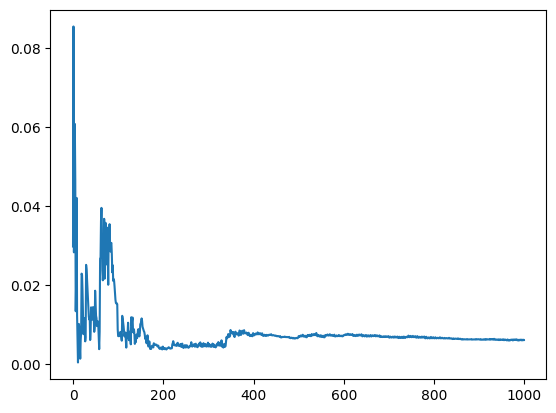

In [85]:
# epochs = 5
# hidden_dims = [64, 64]
# training_rounds = 20

simple_params = {
'train_env': train_env,
'test_env': test_env,
'epochs':2,
'hidden_dims':[64, 64],
'training_rounds':20
}



agent = train_model(**simple_params)

In [86]:
agent.policy_learner

DeepQLearning(
  (_action_representation_module): OneHotActionTensorRepresentationModule()
  (_history_summarization_module): IdentityHistorySummarizationModule()
  (_Q): VanillaQValueNetwork(
    (_model): Sequential(
      (0): Sequential(
        (0): Linear(in_features=12, out_features=64, bias=True)
        (1): ReLU()
      )
      (1): Sequential(
        (0): Linear(in_features=64, out_features=64, bias=True)
        (1): ReLU()
      )
      (2): Sequential(
        (0): Linear(in_features=64, out_features=1, bias=True)
      )
    )
  )
  (_Q_target): VanillaQValueNetwork(
    (_model): Sequential(
      (0): Sequential(
        (0): Linear(in_features=12, out_features=64, bias=True)
        (1): ReLU()
      )
      (1): Sequential(
        (0): Linear(in_features=64, out_features=64, bias=True)
        (1): ReLU()
      )
      (2): Sequential(
        (0): Linear(in_features=64, out_features=1, bias=True)
      )
    )
  )
  (safety_module): IdentitySafetyModule()
)

In [87]:
portfolio_return = test_model(test_env, agent)
print(portfolio_return)

Market Return : -1.37%   |   Portfolio Return : -9.77%   |   position_change : 102   |   
{'loss': np.float64(0.09774537993289467), 'status': 'ok'}


In [88]:
# Short version of search_space
# search_space={
# 'train_env': train_env,
# 'test_env': test_env,
# 'epochs':hp.randint('epochs',2,5),
# 'hidden_dims':hp.choice('hidden_dims',[[64,64],[128,128]]),
# 'training_rounds':hp.randint('training_rounds', 5, 10)
# }



In [90]:
search_space={
'train_env': train_env,
'test_env': test_env,
'epochs': hp.randint('epochs',2,10),
'hidden_dims': hp.choice('hidden_dims',[[64,64],[128,128], [256, 256]]),
'training_rounds': hp.randint('training_rounds', 5, 30),
'learning_rate': hp.loguniform('learning_rate', 1e-6, 1e-1),
'discount_factor': hp.uniform('discount_factor', 0.8, 0.99), # gamma (greediness)
'batch_size': hp.choice('batch_size', [64, 128]),
'target_update_freq': hp.choice('target_update_freq', [1, 5, 10, 24]),
'soft_update_tau': hp.uniform('soft_update_tau', 0.1, .99), 
'is_conservative': hp.choice('is_conservative', [True, False]),
'conservative_alpha': hp.uniform('conservative_alpha', 0.5, 1.0),
}

In [91]:
# dir(bla.historical_info)

In [92]:
#bla.historical_info.columns
#bla.historical_info['position']
#sum(np.abs(np.diff(bla.historical_info['position'])))

In [93]:
# def f(params):
#     epochs = params['epochs']
#     hidden_dims = ['hidden_dims']

  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

  0%|          | 0/6 [00:00<?, ?it/s]


Market Return : 26.39%   |   Portfolio Return : -25.61%   |   position_change : 50   |   
  0%|          | 0/10 [03:59<?, ?trial/s, best loss=?]

 17%|#6        | 1/6 [04:00<20:03, 240.62s/it]


Market Return : 26.39%   |   Portfolio Return : -21.56%   |   position_change : 50   |   
  0%|          | 0/10 [07:58<?, ?trial/s, best loss=?]

 33%|###3      | 2/6 [07:58<15:55, 238.93s/it]


Market Return : 26.39%   |   Portfolio Return : -22.12%   |   position_change : 64   |   
  0%|          | 0/10 [10:18<?, ?trial/s, best loss=?]

 50%|#####     | 3/6 [10:18<09:41, 193.77s/it]


Market Return : 26.39%   |   Portfolio Return : -23.88%   |   position_change : 32   |   
  0%|          | 0/10 [12:46<?, ?trial/s, best loss=?]

 67%|######6   | 4/6 [12:46<05:51, 175.82s/it]


Market Return : 26.39%   |   Portfolio Return : -24.45%   |   position_change : 34   |   
  0%|          | 0/10 [15:11<?, ?trial/s, best loss=?]

 83%|########3 | 5/6 [15:12<02:44, 164.88s/it]


Market Return : 26.39%   |   Portfolio Return : -23.94%   |   position_change : 64   |   
  0%|          | 0/10 [17:44<?, ?trial/s, best loss=?]

100%|##########| 6/6 [17:44<00:00, 177.43s/it]


Market Return : -1.37%   |   Portfolio Return :  1.37%   |   position_change : 2   |   
 10%|█         | 1/10 [17:44<2:39:42, 1064.75s/trial, best loss: -0.013738538436954384]

  0%|          | 0/5 [00:00<?, ?it/s]


Market Return : 26.39%   |   Portfolio Return : -27.47%   |   position_change : 52   |   
 10%|█         | 1/10 [21:24<2:39:42, 1064.75s/trial, best loss: -0.013738538436954384]

 20%|##        | 1/5 [03:39<14:39, 219.76s/it]


Market Return : 26.39%   |   Portfolio Return : -20.51%   |   position_change : 28   |   
 10%|█         | 1/10 [26:11<2:39:42, 1064.75s/trial, best loss: -0.013738538436954384]

 40%|####      | 2/5 [08:27<12:58, 259.63s/it]


Market Return : 26.39%   |   Portfolio Return : -24.18%   |   position_change : 65   |   
 10%|█         | 1/10 [30:52<2:39:42, 1064.75s/trial, best loss: -0.013738538436954384]

 60%|######    | 3/5 [13:08<08:58, 269.29s/it]


Market Return : 26.39%   |   Portfolio Return : -27.16%   |   position_change : 51   |   
 10%|█         | 1/10 [35:26<2:39:42, 1064.75s/trial, best loss: -0.013738538436954384]

 80%|########  | 4/5 [17:42<04:31, 271.15s/it]


Market Return : 26.39%   |   Portfolio Return : -27.68%   |   position_change : 68   |   
 10%|█         | 1/10 [40:28<2:39:42, 1064.75s/trial, best loss: -0.013738538436954384]

100%|##########| 5/5 [22:44<00:00, 272.88s/it]


Market Return : -1.37%   |   Portfolio Return :  1.37%   |   position_change : 1   |   
 20%|██        | 2/10 [40:29<2:45:28, 1241.08s/trial, best loss: -0.013739552176506464]

  0%|          | 0/2 [00:00<?, ?it/s]


Market Return : 26.39%   |   Portfolio Return : -25.19%   |   position_change : 50   |   
 20%|██        | 2/10 [42:03<2:45:28, 1241.08s/trial, best loss: -0.013739552176506464]

 50%|#####     | 1/2 [01:34<01:34, 94.91s/it]


Market Return : 26.39%   |   Portfolio Return : -26.23%   |   position_change : 68   |   
 20%|██        | 2/10 [44:31<2:45:28, 1241.08s/trial, best loss: -0.013739552176506464]

100%|##########| 2/2 [04:02<00:00, 121.38s/it]


Market Return : -1.37%   |   Portfolio Return :  1.37%   |   position_change : 0   |   
 30%|███       | 3/10 [44:32<1:31:36, 785.27s/trial, best loss: -0.013740565916058767] 

  0%|          | 0/2 [00:00<?, ?it/s]


Market Return : 26.39%   |   Portfolio Return : -19.11%   |   position_change : 54   |   
 30%|███       | 3/10 [46:46<1:31:36, 785.27s/trial, best loss: -0.013740565916058767]

 50%|#####     | 1/2 [02:14<02:14, 134.94s/it]


Market Return : 26.39%   |   Portfolio Return : -31.94%   |   position_change : 65   |   
 30%|███       | 3/10 [49:29<1:31:36, 785.27s/trial, best loss: -0.013740565916058767]

100%|##########| 2/2 [04:58<00:00, 149.09s/it]


Market Return : -1.37%   |   Portfolio Return :  1.37%   |   position_change : 1   |   
 40%|████      | 4/10 [49:30<59:18, 593.01s/trial, best loss: -0.013740565916058767]  

  0%|          | 0/9 [00:00<?, ?it/s]


Market Return : 26.39%   |   Portfolio Return : -20.38%   |   position_change : 52   |   
 40%|████      | 4/10 [57:26<59:18, 593.01s/trial, best loss: -0.013740565916058767]

 11%|#1        | 1/9 [07:57<1:03:38, 477.26s/it]


Market Return : 26.39%   |   Portfolio Return : -16.69%   |   position_change : 66   |   
 40%|████      | 4/10 [1:07:05<59:18, 593.01s/trial, best loss: -0.013740565916058767]

 22%|##2       | 2/9 [17:36<1:02:39, 537.13s/it]


Market Return : 26.39%   |   Portfolio Return : -28.84%   |   position_change : 50   |   
 40%|████      | 4/10 [1:18:15<59:18, 593.01s/trial, best loss: -0.013740565916058767]

 33%|###3      | 3/9 [28:46<59:46, 597.68s/it]  


Market Return : 26.39%   |   Portfolio Return : -16.99%   |   position_change : 50   |   
 40%|████      | 4/10 [3:34:09<59:18, 593.01s/trial, best loss: -0.013740565916058767]

 44%|####4     | 4/9 [2:44:56<4:58:57, 3587.46s/it]


Market Return : 26.39%   |   Portfolio Return : -28.74%   |   position_change : 76   |   
 40%|████      | 4/10 [6:15:47<59:18, 593.01s/trial, best loss: -0.013740565916058767]

 56%|#####5    | 5/9 [5:26:34<6:26:02, 5790.69s/it]


Market Return : 26.39%   |   Portfolio Return : -14.00%   |   position_change : 76   |   
 40%|████      | 4/10 [8:57:30<59:18, 593.01s/trial, best loss: -0.013740565916058767]

 67%|######6   | 6/9 [8:08:17<5:56:03, 7121.06s/it]


Market Return : 26.39%   |   Portfolio Return : -21.90%   |   position_change : 52   |   
 40%|████      | 4/10 [10:17:06<59:18, 593.01s/trial, best loss: -0.013740565916058767]

 78%|#######7  | 7/9 [9:27:37<3:31:38, 6349.07s/it]


Market Return : 26.39%   |   Portfolio Return : -18.51%   |   position_change : 77   |   
 40%|████      | 4/10 [10:24:55<59:18, 593.01s/trial, best loss: -0.013740565916058767]

 89%|########8 | 8/9 [9:35:25<1:14:37, 4477.04s/it]


Market Return : 26.39%   |   Portfolio Return : -19.29%   |   position_change : 69   |   
 40%|████      | 4/10 [10:32:36<59:18, 593.01s/trial, best loss: -0.013740565916058767]

100%|##########| 9/9 [9:43:06<00:00, 3887.39s/it]


Market Return : -1.37%   |   Portfolio Return :  1.37%   |   position_change : 1   |   
 50%|█████     | 5/10 [10:32:37<18:02:58, 12995.66s/trial, best loss: -0.013740565916058767]

  0%|          | 0/8 [00:00<?, ?it/s]


Market Return : 26.39%   |   Portfolio Return : -24.55%   |   position_change : 77   |      
 50%|█████     | 5/10 [10:33:21<18:02:58, 12995.66s/trial, best loss: -0.013740565916058767]

 12%|#2        | 1/8 [00:44<05:12, 44.67s/it]


Market Return : 26.39%   |   Portfolio Return : -24.75%   |   position_change : 51   |      
 50%|█████     | 5/10 [10:34:11<18:02:58, 12995.66s/trial, best loss: -0.013740565916058767]

 25%|##5       | 2/8 [01:34<04:47, 47.87s/it]


Market Return : 26.39%   |   Portfolio Return : -27.48%   |   position_change : 58   |      
 50%|█████     | 5/10 [10:35:12<18:02:58, 12995.66s/trial, best loss: -0.013740565916058767]

 38%|###7      | 3/8 [02:35<04:29, 53.83s/it]


Market Return : 26.39%   |   Portfolio Return : -29.17%   |   position_change : 44   |      
 50%|█████     | 5/10 [10:36:14<18:02:58, 12995.66s/trial, best loss: -0.013740565916058767]

 50%|#####     | 4/8 [03:37<03:48, 57.06s/it]


Market Return : 26.39%   |   Portfolio Return : -20.20%   |   position_change : 66   |      
 50%|█████     | 5/10 [10:37:15<18:02:58, 12995.66s/trial, best loss: -0.013740565916058767]

 62%|######2   | 5/8 [04:38<02:55, 58.55s/it]


Market Return : 26.39%   |   Portfolio Return : -32.89%   |   position_change : 66   |      
 50%|█████     | 5/10 [10:38:15<18:02:58, 12995.66s/trial, best loss: -0.013740565916058767]

 75%|#######5  | 6/8 [05:38<01:58, 59.03s/it]


Market Return : 26.39%   |   Portfolio Return : -17.03%   |   position_change : 65   |      
 50%|█████     | 5/10 [10:39:19<18:02:58, 12995.66s/trial, best loss: -0.013740565916058767]

 88%|########7 | 7/8 [06:42<01:00, 60.50s/it]


Market Return : 26.39%   |   Portfolio Return : -18.86%   |   position_change : 69   |      
 50%|█████     | 5/10 [10:40:23<18:02:58, 12995.66s/trial, best loss: -0.013740565916058767]

100%|##########| 8/8 [07:46<00:00, 58.29s/it]


Market Return : -1.37%   |   Portfolio Return :  1.37%   |   position_change : 0   |        
 60%|██████    | 6/10 [10:40:23<9:42:22, 8735.74s/trial, best loss: -0.013740565916058767]  

  0%|          | 0/4 [00:00<?, ?it/s]


Market Return : 26.39%   |   Portfolio Return : -27.33%   |   position_change : 74   |    
 60%|██████    | 6/10 [10:42:57<9:42:22, 8735.74s/trial, best loss: -0.013740565916058767]

 25%|##5       | 1/4 [02:34<07:43, 154.56s/it]


Market Return : 26.39%   |   Portfolio Return : -31.56%   |   position_change : 52   |    
 60%|██████    | 6/10 [10:45:51<9:42:22, 8735.74s/trial, best loss: -0.013740565916058767]

 50%|#####     | 2/4 [05:28<05:31, 165.72s/it]


Market Return : 26.39%   |   Portfolio Return : -29.28%   |   position_change : 52   |    
 60%|██████    | 6/10 [10:48:44<9:42:22, 8735.74s/trial, best loss: -0.013740565916058767]

 75%|#######5  | 3/4 [08:21<02:49, 169.23s/it]


Market Return : 26.39%   |   Portfolio Return : -18.62%   |   position_change : 63   |    
 60%|██████    | 6/10 [10:51:43<9:42:22, 8735.74s/trial, best loss: -0.013740565916058767]

100%|##########| 4/4 [11:20<00:00, 170.14s/it]


Market Return : -1.37%   |   Portfolio Return :  1.37%   |   position_change : 1   |      
 70%|███████   | 7/10 [10:51:44<5:05:07, 6102.38s/trial, best loss: -0.013740565916058767]

  0%|          | 0/4 [00:00<?, ?it/s]


Market Return : 26.39%   |   Portfolio Return : -18.67%   |   position_change : 66   |    
 70%|███████   | 7/10 [10:52:14<5:05:07, 6102.38s/trial, best loss: -0.013740565916058767]

 25%|##5       | 1/4 [00:29<01:29, 29.82s/it]


Market Return : 26.39%   |   Portfolio Return : -13.80%   |   position_change : 57   |    
 70%|███████   | 7/10 [10:52:54<5:05:07, 6102.38s/trial, best loss: -0.013740565916058767]

 50%|#####     | 2/4 [01:10<01:12, 36.02s/it]


Market Return : 26.39%   |   Portfolio Return : -11.38%   |   position_change : 80   |    
 70%|███████   | 7/10 [10:53:42<5:05:07, 6102.38s/trial, best loss: -0.013740565916058767]

 75%|#######5  | 3/4 [01:57<00:41, 41.36s/it]


Market Return : 26.39%   |   Portfolio Return : -25.56%   |   position_change : 27   |    
 70%|███████   | 7/10 [10:54:31<5:05:07, 6102.38s/trial, best loss: -0.013740565916058767]

100%|##########| 4/4 [02:47<00:00, 41.81s/it]


Market Return : -1.37%   |   Portfolio Return :  1.37%   |   position_change : 1   |      
 80%|████████  | 8/10 [10:54:31<2:20:25, 4212.94s/trial, best loss: -0.013740565916058767]

  0%|          | 0/7 [00:00<?, ?it/s]


Market Return : 26.39%   |   Portfolio Return : -15.79%   |   position_change : 80   |    
 80%|████████  | 8/10 [10:55:01<2:20:25, 4212.94s/trial, best loss: -0.013740565916058767]

 14%|#4        | 1/7 [00:29<02:55, 29.31s/it]


Market Return : 26.39%   |   Portfolio Return : -17.06%   |   position_change : 34   |    
 80%|████████  | 8/10 [10:55:34<2:20:25, 4212.94s/trial, best loss: -0.013740565916058767]

 29%|##8       | 2/7 [01:02<02:38, 31.64s/it]


Market Return : 26.39%   |   Portfolio Return : -27.93%   |   position_change : 62   |    
 80%|████████  | 8/10 [10:56:14<2:20:25, 4212.94s/trial, best loss: -0.013740565916058767]

 43%|####2     | 3/7 [01:43<02:23, 35.76s/it]


Market Return : 26.39%   |   Portfolio Return : -28.87%   |   position_change : 43   |    
 80%|████████  | 8/10 [10:57:05<2:20:25, 4212.94s/trial, best loss: -0.013740565916058767]

 57%|#####7    | 4/7 [02:33<02:04, 41.45s/it]


Market Return : 26.39%   |   Portfolio Return : -31.75%   |   position_change : 68   |    
 80%|████████  | 8/10 [10:57:52<2:20:25, 4212.94s/trial, best loss: -0.013740565916058767]

 71%|#######1  | 5/7 [03:21<01:27, 43.67s/it]


Market Return : 26.39%   |   Portfolio Return : -22.79%   |   position_change : 70   |    
 80%|████████  | 8/10 [10:58:36<2:20:25, 4212.94s/trial, best loss: -0.013740565916058767]

 86%|########5 | 6/7 [04:05<00:43, 43.87s/it]


Market Return : 26.39%   |   Portfolio Return : -23.48%   |   position_change : 55   |    
 80%|████████  | 8/10 [10:59:21<2:20:25, 4212.94s/trial, best loss: -0.013740565916058767]

100%|##########| 7/7 [04:49<00:00, 41.40s/it]


Market Return : -1.37%   |   Portfolio Return :  1.37%   |   position_change : 0   |      
 90%|█████████ | 9/10 [10:59:21<49:46, 2986.55s/trial, best loss: -0.013740565916058767]  

  0%|          | 0/2 [00:00<?, ?it/s]


Market Return : 26.39%   |   Portfolio Return : -21.62%   |   position_change : 57   |   
 90%|█████████ | 9/10 [11:01:13<49:46, 2986.55s/trial, best loss: -0.013740565916058767]

 50%|#####     | 1/2 [01:51<01:51, 111.68s/it]


Market Return : 26.39%   |   Portfolio Return : -20.12%   |   position_change : 74   |   
 90%|█████████ | 9/10 [11:03:34<49:46, 2986.55s/trial, best loss: -0.013740565916058767]

100%|##########| 2/2 [04:13<00:00, 126.68s/it]


Market Return : -1.37%   |   Portfolio Return :  1.37%   |   position_change : 0   |    
100%|██████████| 10/10 [11:03:35<00:00, 3981.53s/trial, best loss: -0.013740565916058767]


{'batch_size': np.int64(0),
 'conservative_alpha': np.float64(0.5922524637732596),
 'discount_factor': np.float64(0.8773227674822074),
 'epochs': np.int64(2),
 'hidden_dims': np.int64(1),
 'is_conservative': np.int64(1),
 'learning_rate': np.float64(1.0975208463919917),
 'soft_update_tau': np.float64(0.9392118500908295),
 'target_update_freq': np.int64(1),
 'training_rounds': np.int64(22)}

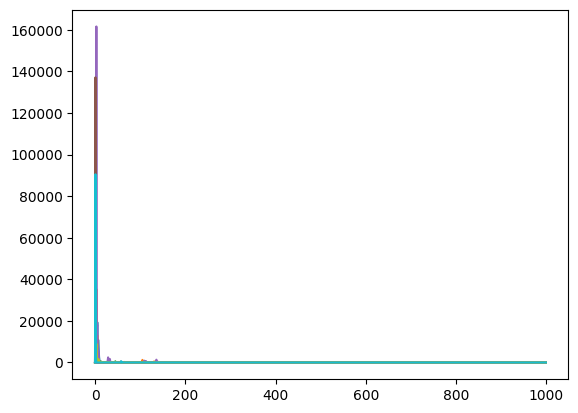

In [94]:
#def train_test_model(train_env, test_env, epochs=5, hidden_dims=[64, 64], training_rounds=20):
trials = Trials()

best = fmin(fn=train_test_model,space=search_space,algo=tpe.suggest, max_evals=10, trials=trials)
best

In [95]:
best

{'batch_size': np.int64(0),
 'conservative_alpha': np.float64(0.5922524637732596),
 'discount_factor': np.float64(0.8773227674822074),
 'epochs': np.int64(2),
 'hidden_dims': np.int64(1),
 'is_conservative': np.int64(1),
 'learning_rate': np.float64(1.0975208463919917),
 'soft_update_tau': np.float64(0.9392118500908295),
 'target_update_freq': np.int64(1),
 'training_rounds': np.int64(22)}

In [96]:
def get_trials(trials):
    trial_df = pd.DataFrame(trials.trials)
    misc = trial_df['misc'].apply(lambda row: pd.Series(row))
    result = trial_df['result'].apply(lambda row: pd.Series(row))
    print(misc)
    vals = misc['vals'].apply(lambda row: pd.Series(row))
    df = pd.concat([result, vals], axis=1)
    return df

expanded_df = get_trials(trials)
expanded_df


   tid                                   cmd workdir  \
0    0  (domain_attachment, FMinIter_Domain)    None   
1    1  (domain_attachment, FMinIter_Domain)    None   
2    2  (domain_attachment, FMinIter_Domain)    None   
3    3  (domain_attachment, FMinIter_Domain)    None   
4    4  (domain_attachment, FMinIter_Domain)    None   
5    5  (domain_attachment, FMinIter_Domain)    None   
6    6  (domain_attachment, FMinIter_Domain)    None   
7    7  (domain_attachment, FMinIter_Domain)    None   
8    8  (domain_attachment, FMinIter_Domain)    None   
9    9  (domain_attachment, FMinIter_Domain)    None   

                                                idxs  \
0  {'batch_size': [0], 'conservative_alpha': [0],...   
1  {'batch_size': [1], 'conservative_alpha': [1],...   
2  {'batch_size': [2], 'conservative_alpha': [2],...   
3  {'batch_size': [3], 'conservative_alpha': [3],...   
4  {'batch_size': [4], 'conservative_alpha': [4],...   
5  {'batch_size': [5], 'conservative_alpha': [5

,loss,status,batch_size,conservative_alpha,discount_factor,epochs,hidden_dims,is_conservative,learning_rate,soft_update_tau,target_update_freq,training_rounds
0,-0.013739,ok,[1],[0.8329027935794213],[0.9311572192948744],[6],[0],[0],[1.0724435280030713],[0.31786436261982176],[1],[20]
1,-0.013740,ok,[1],[0.509893137644049],[0.8915005120293203],[5],[1],[0],[1.0286262923408762],[0.11806733495131497],[2],[26]
2,-0.013741,ok,[0],[0.5922524637732596],[0.8773227674822074],[2],[1],[1],[1.0975208463919917],[0.9392118500908295],[1],[22]
3,-0.013740,ok,[1],[0.9733116467761669],[0.9529873051502105],[2],[0],[1],[1.0519250330708791],[0.3556870071500625],[2],[27]
4,-0.013740,ok,[1],[0.9114545467232746],[0.9705516374285263],[9],[2],[0],[1.077758037490859],[0.6548069257054862],[1],[27]
5,-0.013741,ok,[0],[0.6591098460547438],[0.9032412883424737],[8],[2],[1],[1.0964623998213168],[0.2988405314306032],[3],[8]
6,-0.013740,ok,[0],[0.9075661324566002],[0.9720841649187668],[4],[2],[1],[1.0568137024859527],[0.6840243717123794],[0],[20]
7,-0.013740,ok,[1],[0.9702015326601524],[0.8355584576455852],[4],[0],[1],[1.0216156238674021],[0.4543956177760258],[3],[10]
8,-0.013741,ok,[0],[0.6755727741950681],[0.9515780949955581],[7],[1],[0],[1.0564138603482554],[0.44458739553298454],[2],[6]
9,-0.013741,ok,[0],[0.5629116046346958],[0.9506103313720249],[2],[2],[1],[1.0617805475161814],[0.9758890646418665],[2],[19]


In [97]:
expanded_df.loc[0]

loss                              -0.013739
status                                   ok
batch_size                              [1]
conservative_alpha     [0.8329027935794213]
discount_factor        [0.9311572192948744]
epochs                                  [6]
hidden_dims                             [0]
is_conservative                         [0]
learning_rate          [1.0724435280030713]
soft_update_tau       [0.31786436261982176]
target_update_freq                      [1]
training_rounds                        [20]
Name: 0, dtype: object

In [98]:
trial_df = pd.DataFrame(trials.trials)
trial_df

,state,tid,spec,result,misc,exp_key,owner,version,book_time,refresh_time
0,2,0,None,"{'loss': -0.013738538436954384, 'status': 'ok'}","{'tid': 0, 'cmd': ('domain_attachment', 'FMinI...",None,None,0,2024-10-01 16:43:32.705,2024-10-01 17:01:17.448
1,2,1,None,"{'loss': -0.013739552176506464, 'status': 'ok'}","{'tid': 1, 'cmd': ('domain_attachment', 'FMinI...",None,None,0,2024-10-01 17:01:17.454,2024-10-01 17:24:01.952
2,2,2,None,"{'loss': -0.013740565916058767, 'status': 'ok'}","{'tid': 2, 'cmd': ('domain_attachment', 'FMinI...",None,None,0,2024-10-01 17:24:01.959,2024-10-01 17:28:04.811
3,2,3,None,"{'loss': -0.013739552176506464, 'status': 'ok'}","{'tid': 3, 'cmd': ('domain_attachment', 'FMinI...",None,None,0,2024-10-01 17:28:04.817,2024-10-01 17:33:03.094
4,2,4,None,"{'loss': -0.013739552176506464, 'status': 'ok'}","{'tid': 4, 'cmd': ('domain_attachment', 'FMinI...",None,None,0,2024-10-01 17:33:03.100,2024-10-02 03:16:09.891
5,2,5,None,"{'loss': -0.013740565916058767, 'status': 'ok'}","{'tid': 5, 'cmd': ('domain_attachment', 'FMinI...",None,None,0,2024-10-02 03:16:09.897,2024-10-02 03:23:56.400
6,2,6,None,"{'loss': -0.013739552176506464, 'status': 'ok'}","{'tid': 6, 'cmd': ('domain_attachment', 'FMinI...",None,None,0,2024-10-02 03:23:56.405,2024-10-02 03:35:17.171
7,2,7,None,"{'loss': -0.013739552176506464, 'status': 'ok'}","{'tid': 7, 'cmd': ('domain_attachment', 'FMinI...",None,None,0,2024-10-02 03:35:17.176,2024-10-02 03:38:04.499
8,2,8,None,"{'loss': -0.013740565916058767, 'status': 'ok'}","{'tid': 8, 'cmd': ('domain_attachment', 'FMinI...",None,None,0,2024-10-02 03:38:04.504,2024-10-02 03:42:54.427
9,2,9,None,"{'loss': -0.013740565916058767, 'status': 'ok'}","{'tid': 9, 'cmd': ('domain_attachment', 'FMinI...",None,None,0,2024-10-02 03:42:54.433,2024-10-02 03:47:08.044


In [56]:
trial_df['misc'][0]

{'tid': 0,
 'cmd': ('domain_attachment', 'FMinIter_Domain'),
 'workdir': None,
 'idxs': {'batch_size': [np.int64(0)],
  'conservative_alpha': [np.int64(0)],
  'discount_factor': [np.int64(0)],
  'epochs': [np.int64(0)],
  'hidden_dims': [np.int64(0)],
  'is_conservative': [np.int64(0)],
  'learning_rate': [np.int64(0)],
  'soft_update_tau': [np.int64(0)],
  'target_update_freq': [np.int64(0)],
  'training_rounds': [np.int64(0)]},
 'vals': {'batch_size': [np.int64(1)],
  'conservative_alpha': [np.float64(0.9989178278882772)],
  'discount_factor': [np.float64(0.9507968025152693)],
  'epochs': [np.int64(8)],
  'hidden_dims': [np.int64(0)],
  'is_conservative': [np.int64(0)],
  'learning_rate': [np.float64(1.0917655015568262)],
  'soft_update_tau': [np.float64(0.646111934314871)],
  'target_update_freq': [np.int64(2)],
  'training_rounds': [np.int64(13)]}}

In [40]:
search_space

{'train_env': <OrderEnforcing<TradingEnv<TradingEnv>>>,
 'test_env': <OrderEnforcing<TradingEnv<TradingEnv>>>,
 'epochs': <hyperopt.pyll.base.Apply at 0x225f78ff7f0>,
 'hidden_dims': <hyperopt.pyll.base.Apply at 0x225f78fffd0>,
 'training_rounds': <hyperopt.pyll.base.Apply at 0x225f78ff460>,
 'learning_rate': <hyperopt.pyll.base.Apply at 0x225f7858a90>,
 'discount_factor': <hyperopt.pyll.base.Apply at 0x225f785a110>,
 'batch_size': <hyperopt.pyll.base.Apply at 0x225f7858910>,
 'target_update_freq': <hyperopt.pyll.base.Apply at 0x225f785bdf0>,
 'soft_update_tau': <hyperopt.pyll.base.Apply at 0x225f7858e20>,
 'is_conservative': <hyperopt.pyll.base.Apply at 0x225f785bfd0>,
 'conservative_alpha': <hyperopt.pyll.base.Apply at 0x225f785af20>}

In [71]:
best['hidden_dims']

np.int64(0)

  0%|          | 0/2 [00:00<?, ?it/s]

 50%|█████     | 1/2 [01:16<01:16, 76.22s/it]

Market Return : 26.39%   |   Portfolio Return : -16.36%   |   position_change : 40   |   
Market Return : 26.39%   |   Portfolio Return : -10.32%   |   position_change : 80   |   


100%|██████████| 2/2 [04:27<00:00, 133.73s/it]


TypeError: cannot unpack non-iterable PearlAgent object

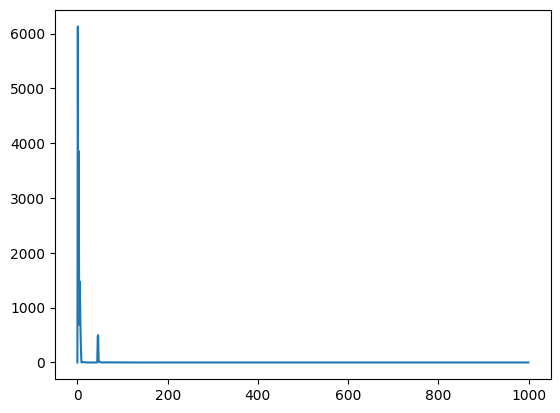

In [105]:
# 
train_env = make_env(train_env_name, train_df, positions, reward_function, trading_fees, daily_rate)
test_env = make_env(test_env_name, test_df, positions, reward_function, trading_fees, daily_rate)

hidden_dims = [[64,64],[128,128], [256, 256]]

best2 = best
best2['train_env'] = train_env
best2['test_env'] = test_env
best2['batch_size'] = 1
#best2['hidden_dims'] = hidden_dims[best2['hidden_dims']]
agent, loss_best2 = train_model(**best2)

In [103]:
best2

{'batch_size': np.int64(0),
 'conservative_alpha': np.float64(0.5922524637732596),
 'discount_factor': np.float64(0.8773227674822074),
 'epochs': np.int64(2),
 'hidden_dims': [128, 128],
 'is_conservative': np.int64(1),
 'learning_rate': np.float64(1.0975208463919917),
 'soft_update_tau': np.float64(0.9392118500908295),
 'target_update_freq': np.int64(1),
 'training_rounds': np.int64(22),
 'train_env': <OrderEnforcing<TradingEnv<TradingEnv>>>,
 'test_env': <OrderEnforcing<TradingEnv<TradingEnv>>>}

In [67]:
best

agent = train_model(**best_test)

NameError: name 'best_test2' is not defined

In [59]:
# #env = GymEnvironment(env)

# train_env = GymEnvironment(train_env)
# test_env = GymEnvironment(test_env)

In [60]:


# num_actions = train_env.action_space.n
# agent = PearlAgent(
#     policy_learner=DeepQLearning(
#         state_dim=train_env.observation_space.shape[0],
#         action_space=train_env.action_space, 
#         hidden_dims=[64, 64],
#         training_rounds=20,
#         action_representation_module=OneHotActionTensorRepresentationModule(
#             max_number_actions=num_actions
#         ),
#     ),
#     replay_buffer=FIFOOffPolicyReplayBuffer(10_000),
# )


In [61]:
## Probably unnecessary
# observation, action_space = train_env.reset()
# observation.shape,action_space

((9,),
 <pearl.utils.instantiations.spaces.discrete_action.DiscreteActionSpace at 0x2b7ccb27a30>)

In [62]:
# losses=[]

In [ ]:
# n_epochs=1
# for i in tqdm(range(n_epochs)):
#     observation, action_space = train_env.reset()
#     agent.reset(observation, action_space)
#     done = False
#     while not done:
#         action = agent.act(exploit=False)
#         action_result = train_env.step(action)
#         agent.observe(action_result)
#         loss=agent.learn()
#         [losses.append(l) for l in loss['loss']]
#         done = action_result.done


In [64]:
# len(losses)

59900

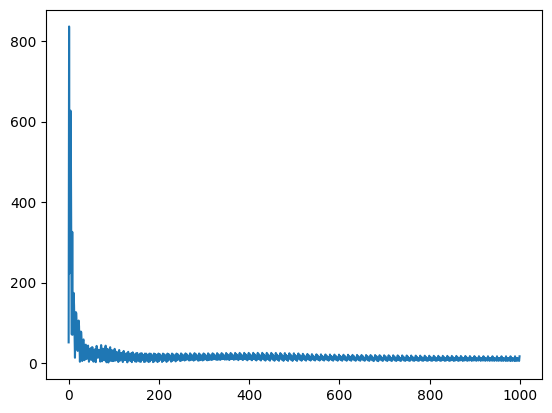

In [65]:
plt.plot(losses[:1000])

In [ ]:
# observation, action_space = env.reset()
# agent.reset(observation, action_space)
# done = False
# while not done:
#     action = agent.act(exploit=True)
#     action_result = env.step(action)
#     agent.observe(action_result)
#     # loss=agent.learn()
#     # [losses.append(l) for l in loss['loss']]
#     done = action_result.done

observation, action_space = test_env.reset()
agent.reset(observation, action_space)
done = False
while not done:
    action = agent.act(exploit=True)
    action_result = test_env.step(action)
    agent.observe(action_result)
    # loss=agent.learn()
    done = action_result.done

In [67]:
# Get back the original test environment (get it out of its Pearl wrapper)
og_env=test_env.env.unwrapped

In [68]:
og_env.save_for_render()

In [69]:
renderer = Renderer(render_logs_dir="render_logs")

# Add Custom Lines (Simple Moving Average)
renderer.add_line( name= "sma10", function= lambda df : df["close"].rolling(10).mean(), line_options ={"width" : 1, "color": "purple"})
renderer.add_line( name= "sma20", function= lambda df : df["close"].rolling(20).mean(), line_options ={"width" : 1, "color": "blue"})

renderer.run()

 * Serving Flask app 'gym_trading_env.renderer'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit


In [ ]:
#action = agent.act(exploit=False)
#action

In [ ]:
# action_result